Inspired by https://github.com/aaumaitre/taylor_swift
    

Importing Libraries

In [1]:
import string
import pandas as pd
import numpy as np
import tidytext as tt
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

Import Data

In [2]:
lyrics_data = pd.read_csv('./final_taylor_swift_lyrics.tsv', sep='\t')
lyrics_data.head()
# lyrics_data.describe()


,index,album,song_title,lyric,line_number,release_date
0,0,Lover,Lover,[Verse 1],0,2019-08-16
1,0,Lover,Lover,We could leave the Christmas lights up 'til Ja...,1,2019-08-16
2,0,Lover,Lover,"And this is our place, we make the rules",2,2019-08-16
3,0,Lover,Lover,"And there's a dazzling haze, a mysterious way ...",3,2019-08-16
4,0,Lover,Lover,Have I known you 20 seconds or 20 years?,4,2019-08-16


Cleanup data, remove punctuation and lines in []

In [3]:
uniqueValues = lyrics_data['album'].unique()

Disregarding the concert and repackage albums (evermore was sorely missed)

In [4]:
albums = ['folklore', 'Lover', 'reputation', '1989 (Deluxe)', 'Fearless', 'Red', 'Speak Now', 'Taylor Swift']
lyrics_data = lyrics_data[lyrics_data['album'].isin(albums)]
lyrics_data.head()


,index,album,song_title,lyric,line_number,release_date
0,0,Lover,Lover,[Verse 1],0,2019-08-16
1,0,Lover,Lover,We could leave the Christmas lights up 'til Ja...,1,2019-08-16
2,0,Lover,Lover,"And this is our place, we make the rules",2,2019-08-16
3,0,Lover,Lover,"And there's a dazzling haze, a mysterious way ...",3,2019-08-16
4,0,Lover,Lover,Have I known you 20 seconds or 20 years?,4,2019-08-16


In [5]:
lyrics_data = lyrics_data[~lyrics_data.lyric.str.contains('\[')]
lyrics_data = lyrics_data[~lyrics_data.song_title.str.contains('\[')]
#lyrics_data['lyric'] = lyrics_data['lyric'].str.replace('[{}]'.format(string.punctuation), '')
lyrics_data.head()


,index,album,song_title,lyric,line_number,release_date
1,0,Lover,Lover,We could leave the Christmas lights up 'til Ja...,1,2019-08-16
2,0,Lover,Lover,"And this is our place, we make the rules",2,2019-08-16
3,0,Lover,Lover,"And there's a dazzling haze, a mysterious way ...",3,2019-08-16
4,0,Lover,Lover,Have I known you 20 seconds or 20 years?,4,2019-08-16
6,0,Lover,Lover,Can I go where you go?,6,2019-08-16


Lyrics to words

In [6]:
words_data = tt.unnest_tokens(lyrics_data, "word", "lyric")
words_data.head()

,index,album,song_title,line_number,release_date,word
1,0,Lover,Lover,1,2019-08-16,we
1,0,Lover,Lover,1,2019-08-16,could
1,0,Lover,Lover,1,2019-08-16,leave
1,0,Lover,Lover,1,2019-08-16,the
1,0,Lover,Lover,1,2019-08-16,christmas


Get count of words

In [7]:
words_freq = words_data['word'].value_counts()
words_freq

you            1939
i              1925
the            1362
and            1179
me              731
               ... 
translation       1
laptop            1
backroads         1
earthquakes       1
plus              1
Name: word, Length: 2812, dtype: int64


Removing stop words

In [8]:
stop = stopwords.words('english')
#stop = stop.str.replace('[{}]'.format(string.punctuation), '')

words_data['word'] = words_data['word'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
#words_data['word']
words_data['word'].replace('', np.nan, inplace=True)
words_mod_freq = words_data['word'].value_counts().nlargest(15)
words_mod_freq


like     335
know     325
im       313
oh       308
never    260
love     230
dont     217
na       215
cause    188
time     182
back     176
youre    176
one      157
want     157
got      147
Name: word, dtype: int64

Plotting the word frequency

<AxesSubplot:>

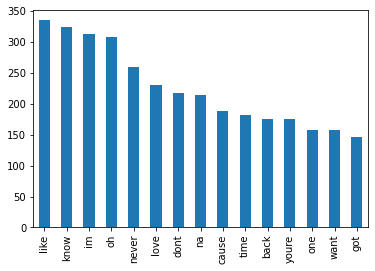

In [9]:
words_mod_freq.plot(kind="bar")

Sentiment Analysis

In [10]:
# from wordcloud import WordCloud 

# df = words_data[words_data.word.notna()]
# print(df.head())
# textt = " ".join(word for word in df.word)
# wordcloud = WordCloud(stopwords=words_mod_freq).generate(textt)
# plt.imshow(wordcloud, interpolation='bilinear')

Get Sentiment Analyser

In [11]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()


Evalulate sentiment

In [12]:
def valuation_formula(x):
    return max(sia.polarity_scores(x), key=sia.polarity_scores(x).get)

lyrics_data['sentiment'] = lyrics_data.apply(lambda row: valuation_formula(row['lyric']), axis=1)


Visualise sentiment (Sentiment, Album, Freq), classify sentiment of song by couting sentiment of lines

neu         4724
compound     455
pos          166
neg          156
Name: sentiment, dtype: int64

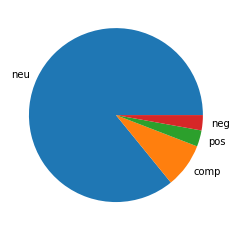

In [13]:
#plotdata = pd.DataFrame(lyrics_data['sentiment'], lyrics_data['album'])
sentiment_freq = lyrics_data['sentiment'].value_counts()
plt.pie(sentiment_freq, labels = ['neu', 'comp', 'pos', 'neg'])
sentiment_freq.head()


Grouping sentiment by song

In [14]:
sent_list = list()

for i in lyrics_data['song_title'].unique():
    y = lyrics_data[lyrics_data['song_title'] == i ].sum().lyric
    m = max(sia.polarity_scores(y)['neg'], sia.polarity_scores(y)['pos'])
    album_name = lyrics_data['album'].where(lyrics_data['song_title'] == i).dropna().values[0]
    val_list = list(sia.polarity_scores(y).values())
    if val_list.index(m) == 2:        
        sent_list.append([i, album_name,'pos'])
    else:
        sent_list.append([i, album_name,'neg'])
        
# sent_list


In [15]:
sent_df = pd.DataFrame(sent_list, columns =['song_title', 'album', 'sentiment'])
sent_df.head()

,song_title,album,sentiment
0,Lover,Lover,pos
1,Look What You Made Me Do,reputation,neg
2,End Game (Ft. Ed Sheeran & Future),reputation,pos
3,ME! (Ft. Brendon Urie),Lover,pos
4,You Need To Calm Down,Lover,pos


Grouping sentiment by album

In [16]:
album_sent_list = list()
for i in lyrics_data['album'].unique():
    album_sent = sent_df['sentiment'].where(sent_df['album'] == i).dropna().values
    (unique, counts) = np.unique(album_sent, return_counts=True)

    frequencies = np.asarray((unique, counts)).T
    album_sent_list.append((i, str(frequencies[0][1]), str(frequencies[1][1])))
    
album_sent_list

[('Lover', '6', '12'),
 ('reputation', '3', '12'),
 ('1989 (Deluxe)', '6', '13'),
 ('folklore', '9', '7'),
 ('Fearless', '4', '9'),
 ('Red', '1', '18'),
 ('Taylor Swift', '3', '8')]

In [17]:
album_sent_df = pd.DataFrame(album_sent_list, columns = ['album', 'neg', 'pos'])
album_sent_df.head()

,album,neg,pos
0,Lover,6,12
1,reputation,3,12
2,1989 (Deluxe),6,13
3,folklore,9,7
4,Fearless,4,9


Bar graph time

<AxesSubplot:xlabel='album'>

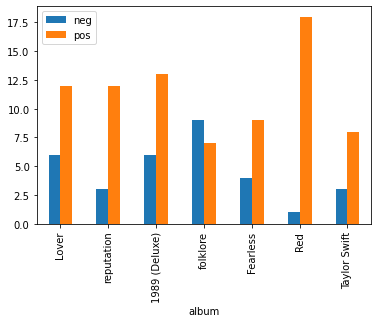

In [18]:
#album_sent_df.plot(x="album", y=["neg", "pos"], kind="bar")
album_sent_df['neg']=album_sent_df['neg'].astype(float)
album_sent_df['pos']=album_sent_df['pos'].astype(float)
album_sent_df[["album", "neg", "pos"]].plot(x="album", kind="bar")